In [1]:
from numba import jit
from numpy import cos, sin, pi
from random import random
from scipy.optimize import minimize
from scipy.special import binom
import functools
import itertools
import itertools
import collections
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import time

# Performance of 2-step threshold algorithm

In [2]:
def make_qfn(T):
    def f(x):
        """This function can handle vectorized operations"""
        return (x < T)*2 - 1
    return f
#     return lambda x: 1 if x < T else -1

qfns = [make_qfn(T) for T in range(10000)]

In [3]:
# This now inputs an array, so it cannot be cached with functools.
# @functools.lru_cache(maxsize=int(1e7))
def binompmf(tot, times, p):
    return p**times * (1 - p)**(tot-times) * binom(tot, times) 

In [4]:
@functools.lru_cache(maxsize=4096)
def Z1plus(qf, n):
    return 2**(-n)*np.sum([qf(m+1)*binom(n, m) for m in range(0, n+1)])

@functools.lru_cache(maxsize=4096)
def Z1minus(qf, n):
    return (-1)*2**(-n)*np.sum([binom(n, m)*qf(m) for m in range(0, n+1)])

@functools.lru_cache(maxsize=int(5e7))
def bigQ(qf, n, l, r, a, b):
    return qf((n-l-r)*(1-a)/2 + (l+r)*(1+a)/2 + (1+b)/2)

In [5]:
def bigQ_all(qf, n, l_max, r_max, a, b):
    vals = np.meshgrid(range(l_max), range(r_max))
    def bigQ_f(lr):
        l = lr[0]
        r = lr[1]
        return qf((n-l-r)*(1-a)/2 + (l+r)*(1+a)/2 + (1+b)/2)
    return bigQ_f(vals)

In [6]:
@functools.lru_cache(maxsize=int(1e7))
def Z2(Z1, Z0, match, q2, n, k, p_plus, p_minus):
    bp_minus = binompmf(n-k, np.arange(n-k+1), p_minus)
    bp_plus = binompmf(k, np.arange(k+1), p_plus)
    
    bq_all = bigQ_all(q2, n, k+1, n-k+1, Z1*Z0, match)
    inter = np.sum(bq_all*bp_plus, axis=1)
    out = np.sum(bp_minus*inter)

    return Z1*out

In [7]:
def final(n, T1, T2):
    """
    Calculates -1/2 * <Z_i Z_j>.
    It should be odd function over the midpoint. Both T=0 and T> n+1 should be 0 (i.e. no improvement).
    Recall that n = D-1, so this expression is for a (n+1)-regular graph.
    """
    out = 0
    q1 = qfns[T1]
    q2 = qfns[T2]
    p_plus = (1 + Z1plus(q1, n))/2
    p_minus = (1 + Z1minus(q1, n))/2
    
    binom_n = np.array([binom(n, k) for k in range(n+1)])
    
    med = []
    for k in range(n+1):
        inter = []
        for u in range(n+1):
            equal = Z2(q1(k+1), 1, q1(k+1)*q1(u+1), q2, n, k, p_plus, p_minus) * Z2(q1(u+1), 1, q1(k+1)*q1(u+1), q2, n, k, p_plus, p_minus)
            unequal = Z2(q1(k), 1, -q1(k)*q1(u),q2, n, k, p_plus, p_minus) * Z2(-q1(u), -1, -q1(k)*q1(u), q2, n, k, p_plus, p_minus)
            inter.append( 0.5 * (equal + unequal))
            
        med.append(np.sum(binom_n * inter))
        
    out = np.sum(binom_n * med)
    return -0.5 * 2**(-2*n) * out

### Finding the best threshold

Let's confirm the best range of threshold. Notice the pattern in optimal threshold value in the below plot:

TODO include this in the paper

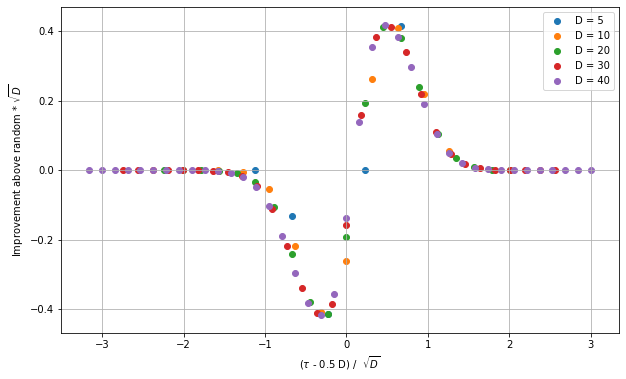

In [8]:
plt.figure(figsize=(10, 6))
for D in [5, 10, 20, 30, 40]:
    xs = np.arange(0, D)
    plt.scatter((xs - D/2)*D**-0.5, [D**0.5 * final(D-1, t, t) for t in xs], label="D = %i" % D)
plt.grid()
plt.xlabel("($τ$ - 0.5 D) /  $\sqrt{D}$")
plt.ylabel("Improvement above random * $\sqrt{D}$")
plt.legend()

This gives me confidence that the optimal threshold value is between $D/2$ and $D/2 + \sqrt{D}$.

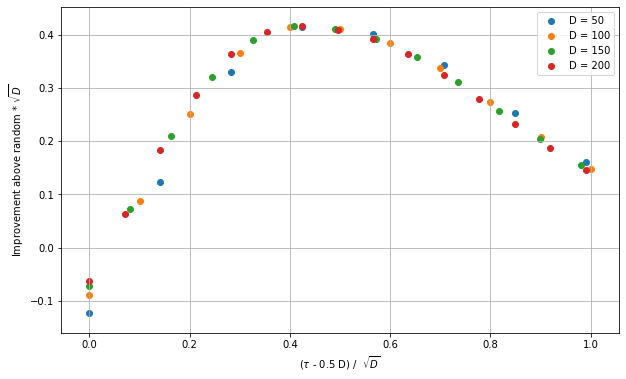

In [9]:
plt.figure(figsize=(10, 6))
for D in [50, 100, 150, 200]:
    xs = np.arange(int(D/2), int(D/2) + int(D**0.5) + 1)
    plt.scatter((xs - D/2)*D**-0.5, [D**0.5*final(D-1, t, t) for t in xs], label="D = %i" % D)
plt.grid()
plt.xlabel("($τ$ - 0.5 D) /  $\sqrt{D}$")
plt.ylabel("Improvement above random * $\sqrt{D}$")
plt.legend()

From the above plot, I expect the optimal threshold to be approximately $D/2 + 0.4 \sqrt{D}$ at large values of $D$.

### Computing for D < 500

In [10]:
def get_max_final(d):
    """
    This finds the optimal threshold assuming tau_1 = tau_2.
    To speed this up, I limit my search to roughly (D/2 + k_min \sqrt{D}, D/2 + k_max \sqrt{D}).
    I expect the optimal k to be approximately 0.4 - 0.5.
    """
    k_min, k_max = 0, 1.5
    if d > 150:
        k_min, k_max = 0.25, 0.52
    elif d > 60:
        k_min, k_max = 0.25, 0.6
  
    inps = range(int((d-1)/2 + k_min*(d-1)**0.5 ), int((d-1)/2 + max(10, k_max*(d-1)**0.5 + 1)))
    vals = [final(d-1, t, t) for t in inps]
    return max(vals), inps[vals.index(max(vals))]

In [11]:
# The multiprocessing library will make this run much faster.
pool = multiprocessing.Pool(4)
ds = range(2, 500 + 1)

In [ ]:
%%time
deltas = pool.map(get_max_final, ds)
pool.close()

In [ ]:
for _ in [Z2, bigQ, Z1minus, Z1plus]:
    print(_.__name__, _.cache_info())

In [ ]:
plt.figure(figsize=(10, 6))
deltas2 = [d**0.5 * delt[0] for d, delt in zip(ds, deltas)]
plt.plot(ds[:len(deltas2)], deltas2, label="2-step, girth > 5")
plt.grid()

In [ ]:
# the last few values, to get a sense of the value at large D
deltas2[-5:]

In [ ]:
ts = [i[1] for i in deltas]
# t = d/2 + ksqrtd
# (t - d/2)**2 = k**2 d
plt.figure(figsize=(10, 6))
plt.plot(ds, ((np.array(ts) - np.array(ds)/2)* (np.array(ds))**-.5))
plt.ylim(0)
plt.xlabel("D (of a D-regular graph)")
plt.ylabel("Optimal $k$, given $τ= D/2 + k \sqrt{D}$")
plt.grid()
plt.savefig("2step_optimalt.png")

### Code optimization

On Dec 24 2020, I worked on optimizing this code. A few notes:
* cython doesn't work with functools
* I couldn't get numba_scipy to work; I couldn't find the right versions of np, scipy, numba that were all compatible.
* In the binompmf using np.arange is incompatible with lru_cache, but the np.arange is a bit faster
* I tried an scipy.optimize.minimize guess, but it wasn't that accurate.


In [ ]:
# # these code profilers really helped.
# %load_ext line_profiler
# %lprun -f Z2 get_max_final(21)
# %prun get_max_final(508)

### Unequal thresholds

In [ ]:
def get_max_final_2(d):
    """
    This finds the optimal threshold for any tau_1 and tau_2.
    This looks over all tau > (d-1)/2 to find the best threshold.
    """
    assert d < 50, "this takes a very long time"
  
    inps = range(int((d-1)/2), int(d+2))
    vals = [final(d-1, t, t2) for t in inps for t2 in inps]
    
    best = vals.index(max(vals))
    return max(vals), inps[best // len(inps)], inps[best % len(inps)]

Let's find the optimal threshold for D < 50.

In [ ]:
%%time
unequal_thresholds = [get_max_final_2(i) for i in range(2, 50)]

Printing out the best results for D < 20:

In [ ]:
for i in range(2, 20):
    print(i, get_max_final(i), get_max_final_2(i))

# Performance of QAOA$_2$

In [ ]:
# the just-in-time compilation massively improves the runtime of this function.
@jit(nopython=True, nogil=True)
def qaoa2(beta_2, gamma_2, beta_1, gamma_1, D):
    """Cut fraction with p=2 QAOA on D-regular girth > 5 graphs"""
    c = cos(2*beta_2)
    s = sin(2*beta_2)
    m = cos(gamma_2)
    n = sin(gamma_2)
    r = cos(2*beta_1)
    t = sin(2*beta_1)
    G = cos(gamma_1)
    H = sin(gamma_1)

    A = -2*c*c*r*t*H*G**(D-1)
    bpt1 = 0.5*s*c*(
        (1 + r)*(-m*r*H - n*G)*((m*G - n*r*H)**(D-1))
        + (1 - r)*(m*r*H - n*G)*((m*G + n*r*H)**(D-1))
    )
    bpt2 = 0.5*s*c*t*(
        (m*t*(G**(D-1))*H + (1j)*n)*((m + (1j)*n*t*(G**(D-1))*H)**(D-1))
        + (m*t*(G**(D-1))*H - (1j)*n)*((m - (1j)*n*t*(G**(D-1))*H)**(D-1))
    )
    Ea = s*s*t*H * 0.5 * \
        ((1+r)*(m*G - n*H*r)**(D-1) - (1-r)*(m*G + n*H*r)**(D-1))
    Eb = (m + (1j)*n * G**(D-1) * H*t)**(D-1) + \
        (m - (1j)*n * G**(D-1) * H*t)**(D-1)
    return 0.5 - 0.5 * (A + 2*(bpt1 + bpt2) + Ea*Eb)

In [ ]:
qaoa2_d_deg = lambda i, d: -qaoa2(*i, d).real

def get_best(d):
    """This runs the optimization 100 times, or 150 times if d < 20, and takes the best value."""
    best = None
    val = 0
    i = 0
    while i < 100 or (d < 20 and i < 150):
        i += 1
        init_val = [random()*(i % 2 + 1)*pi for i in range(4)]
        result = minimize(qaoa2_d_deg, init_val, args=(d), options={'fatol': 1e-20}, method='Nelder-Mead')
        if not best or result.fun < best.fun:
            best = result
            val = d**0.5 * (-best.fun - 0.5)
    return best

In [ ]:
%%time
pool = multiprocessing.Pool(4)
results = pool.map(get_best, ds)
pool.close()

In [ ]:
out = {d: -r.fun - 0.5 for d, r in zip(ds, results)}
qaoavals = np.array([out[k]*k**0.5 for k in sorted(out)])

print(sum (qaoavals[:-1] < qaoavals[1:]), "values that are not descending")
assert sum ( qaoavals < 0.407) == 0, "all values should be at least 0.407"
# the last few values, to get a sense of the value at large D
print(qaoavals[-5:])

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot([k for k in sorted(out)], qaoavals)
plt.grid()
plt.xlabel("D (of a D-regular graph)")
plt.ylabel("Scaled performance of QAOA$_2$")
plt.ylim(0.4)

### Confirming known results

I confirm the results for $D=2$ (5/6 cut fraction) and $D=3$ (0.7559 cut fraction):

In [ ]:
for D in range(2, 4):
    print("D=%i" % D, "cut fraction:", -results[ds.index(D)].fun, "input angles in degrees:", 180/pi*results[ds.index(D)].x)

For $D=3$, the input angles match the values listed in Table I of Wurtz 2020, up to degeneracy in the input ($\pi/2$ in $\beta$). Other input angles will also achieve this maximum; for example, consider the angles $(\beta_2, \gamma_2, \beta_1, \gamma_1) = (16.8^{\circ},51.4^{\circ}, 31.8^{\circ}, 28.0^{\circ}$):

In [ ]:
qaoa2(*np.array([16.8, 51.4, 31.8, 28.0])*pi/180, 3).real

For $D=2$, I verify with SymPy that the formulas are in fact equal:

In [ ]:
def f2(beta_1, gamma_1, beta_2, gamma_2):
    c = cos(2*beta_2)
    s = sin(2*beta_2)
    m = cos(gamma_2)
    n = sin(gamma_2)
    r = cos(2*beta_1)
    t = sin(2*beta_1)
    G = cos(gamma_1)
    H = sin(gamma_1)
    pt1 = c*c*r*t*G*H
    pt2 = -s*c*m*n*(r*r*H*H - G*G)
    pt3 = -s*c*G*H*(t*t - r*r)*(m*m - n*n)
    pt4 = -s*s*t*H*m*r*(m*G - n*H)
    return 0.5 + pt1 + pt2 + pt3 + pt4
    
def ring(beta_1, gamma_1_input, beta_2, gamma_2_input):
    gamma_1 = -gamma_1_input/2
    gamma_2 = -gamma_2_input/2
    Fbyn = 1/64 * (
        -7*cos(4*beta_1 + 4*beta_2 + 4*gamma_1 + 4*gamma_2)
        -6*cos(4*beta_1 + 4*beta_2 + 4*gamma_1)
        +3*cos(4*beta_1 + 4*beta_2 - 4*gamma_1 + 4*gamma_2)
        +4*cos(4*beta_1 + 4*beta_2 + 4*gamma_2)
        +3*cos(4*beta_1 - 4*beta_2 + 4*gamma_1 + 4*gamma_2)
        -6*cos(4*beta_1 - 4*beta_2 + 4*gamma_1)
        -3*cos(4*beta_1 - 4*beta_2 - 4*gamma_1 + 4*gamma_2)
        +4*cos(4*beta_1 + 4*gamma_1 + 4*gamma_2)
        -4*cos(4*beta_1 + 4*gamma_1)
        -4*cos(4*beta_1 + 4*gamma_2)
        -3*cos(-4*beta_1 + 4*beta_2 + 4*gamma_1 + 4*gamma_2)
        +6*cos(-4*beta_1 + 4*beta_2 + 4*gamma_1)
        +3*cos(-4*beta_1 + 4*beta_2 - 4*gamma_1 + 4*gamma_2)
        +7*cos(-4*beta_1 - 4*beta_2 + 4*gamma_1 + 4*gamma_2)
        +6*cos(-4*beta_1 - 4*beta_2 + 4*gamma_1)
        -3*cos(-4*beta_1 - 4*beta_2 - 4*gamma_1 + 4*gamma_2)
        -4*cos(-4*beta_1 - 4*beta_2 + 4*gamma_2)
        -4*cos(-4*beta_1 + 4*gamma_1 + 4*gamma_2)
        +4*cos(-4*beta_1 + 4*gamma_1)
        +4*cos(-4*beta_1 + 4*gamma_2)
        -6*cos(4*beta_2 + 4*gamma_1 + 4*gamma_2)
        -6*cos(4*beta_2 - 4*gamma_1 + 4*gamma_2)
        -4*cos(4*beta_2 + 4*gamma_2)
        +6*cos(-4*beta_2 + 4*gamma_1 + 4*gamma_2)
        +6*cos(-4*beta_2 - 4*gamma_1 + 4*gamma_2)
        +4*cos(-4*beta_2 + 4*gamma_2)
    )
    return 0.5 * (1 - Fbyn)

In [ ]:
# evaluates to 0
from sympy import symbols, simplify, collect, expand, expand_trig, cos, sin
b1, g1, b2, g2 = symbols('b1 g1 b2 g2')
result = simplify(
    collect(
        expand(expand_trig(f2(b1, g1, b2, g2))) - expand(expand_trig(ring(b1, g1, b2, g2)))
    , cos(b1))
)
print(result)
assert result == 0

# Performance of 1-step algorithms

This reproduces work done by Wang et al 2018 and Hastings 2019.

In [ ]:
def q(k, threshold):
    """Works for numpy arrays"""
    return (1-(k >= threshold)*2)

def calc_performance(D, T):
    """
    This calculates the performance over random after 1 step of Hastings' thresholding algorithm. 
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    s1 = 0
    s2 = 0
    # go through # of agreeing neighbors, from 0 through D-1
    for i in range(D):
        # factor out two copies of 2^-n, n=D-1
        s1 += binom(D-1, i)*q(i+1, T)
        s2 += binom(D-1, i)*q(i, T)
    return -0.5 * 0.5 * (s1**2 - s2**2) * 2**(-2*(D-1))

hrss_1 = [D**0.5*max([calc_performance(D, int((D-1)/2+k)) for k in range(0, max(int(D**0.5 + 1), 10))]) for D in ds]

In [ ]:
def qaoa1(D):
    """Best QAOA1 performance on triangle-free graphs."""
    d = D-1
    return 0.5 * (d/(d+1))**(d/2)
qaoa_1 = [qaoa1(D) for D in ds]

# Comparison plots

In [ ]:
plt.figure(figsize=(10, 6))
diff_thresholds = [x[0]*d**0.5 for x, d in zip(unequal_thresholds, ds[:len(unequal_thresholds)])]
plt.plot(ds[:len(diff_thresholds)], diff_thresholds, label="Best of 2-step threshold")
plt.plot(ds, deltas2, label="Best of 2-step threshold where $τ_1 = τ_2$")
plt.plot(ds, qaoavals, label="Best of QAOA$_2$")
plt.plot(ds, hrss_1, label="Best of 1-step threshold")
plt.plot(ds, qaoa_1, label="Best of QAOA$_1$")
plt.grid()
plt.xlim(0, 500)
plt.xlabel("D (of a D-regular graph)")
plt.ylabel("Scaled performance")
plt.legend()
plt.savefig("all_results.png")

QAOA$_2$ does win in a few cases:

In [ ]:
print("D where qaoa wins")
weirds = np.array(ds)[qaoavals > deltas2]
print(weirds)
print("total:", len(weirds))

In [ ]:
print("D where qaoa wins even with unequal thresholds")
weirds = np.array(ds)[:len(diff_thresholds)][qaoavals[:len(diff_thresholds)] > diff_thresholds]
print(weirds)
print("total:", len(weirds))

# Small-degree local classical algorithms

In [ ]:
print("improvement above random quantum vs classical")
for i in range(4):
    print("D =", 2+i, qaoavals[i] * (2+i)**-0.5, "vs", diff_thresholds[i] * (2+i)**-0.5)

### Reproducing the 1-step local classical algorithms

In [ ]:
def local_1(c, n1, n2, s1, s2):
    """Implements a 1-step local linear algorithm given the description in Hastings 2019."""
    v1 = n1 - c*s1 - c*n2
    v2 = n2 - c*s2 - c*n1

    # if any of (v1, v2) is 0 it (correctly) gives a 1/2 chance of success
    return 0.5 - 0.5*np.sign(v1)*np.sign(v2)

Hastings describes the improvement over random of $D=3$ at $c=0.599$ with initial values $[-1, -1/3, 1/3, 1]$, noting that it was at least better than QAOA$_1$'s value of 0.1925 but not as good as a uniform distribution at 0.1980.

In [ ]:
c = 0.599
d = 3
poss = np.array([-1, -1/3, 1/3, 1])
nbriter = list(itertools.product(*[poss,]*(d-1)))
nbrsums = np.sum(nbriter, axis=1)

def t(args):
    return local_1(c, *args)

ct = np.sum ( t(np.meshgrid(poss, poss, nbrsums, nbrsums)) )
improvement = ct / len(poss)**(2*d) - 0.5
print("poss = ", poss, "c = ", c, "success = ", improvement)
assert improvement > 0.1925, "should be better than QAOA1"
assert improvement < 0.1980, "should be less than uniform dist"

### Implementing the 2-step local classical algorithm

The code that searches is extremely optimized. Initially, it would have taken 1.5s for D=3; now it takes 5ms for D=3. It groups different possibilities and multiplies them by their occurrence probability, greatly reducing the $O(m^{D^2})$ runtime given $m$ initial values.

In [ ]:
# # Code profiling
# %lprun -f local_2 run(0.6, 1.1, 3, [-1, 0, 1])
# %timeit run(0.6, 1.1, 3, [-1,1])
# %prun run(0.6, 1.1, 3, [-1,-1/3,1/3,1])

In [ ]:
def local_2(d, c, c2, n1, n2,  s1, s2, nbr_nbrsum1, nbr_nbrsum2):
    """
    Implements a 2-step local linear algorithm given the description in Hastings 2019.
    This has been optimized greatly.
    A few notation changes: (c0, c1) are now (c, c2).
    The s1, s2 correspond to sums of the neighbors of the nodes connected to the edge.
    The nbr_nbrsum1, nbr_nbrsum2 values correspond to sums of the neighbors of the neighbors of the nodes connected to the edge.
    """
#     v1 = n1 - c*s1 - c*n2
#     v2 = n2 - c*s2 - c*n1
#     x1 = s1 - c*nbr_nbrsum1 - (d-1)*c*n1
#     x2 = s2 - c*nbr_nbrsum2 - (d-1)*c*n2
#     z1 = v1 - c2*x1 - c2*v2 
#     z2 = v2 - c2*x2 - c2*v1
    
    cc2 = c*c2
    cpc2 = c+c2
    cc2dp1 = 1+cc2*d
    z1 = n1*cc2dp1 - (s1+n2)*cpc2 + cc2*(s2 + nbr_nbrsum1)
    z2 = n2*cc2dp1 - (s2+n1)*cpc2 + cc2*(s1 + nbr_nbrsum2)
    
    # if any of (v1, v2) is 0 it (correctly) gives a 1/2 chance of success
    return 0.5 - 0.5* np.sign(z1)*np.sign(z2)

In [ ]:
def get_iters(*poss, d):
    nbriter = np.array(list(itertools.product(*[list(poss),]*(d-1))))
    nbr_nbriter = list(itertools.product(*[nbriter,]*(d-1)))
    nbrsums = np.sum(nbriter, axis=1)
    nbr_nbrsums = np.sum(nbr_nbriter, axis=(1, 2))
    return nbrsums, nbr_nbrsums

In [ ]:
def run(c, c2, d, poss):
    """
    Note that the runtime is extremely poor: len(poss) ** (2*d(d-1) + 2)
    Fortunately, using np.unique helps significantly.
    """
    
    nbrsums, nbr_nbrsums = get_iters(*poss, d=d)
    
    poss_u = np.unique(poss, return_counts=True)
    nbr_u = np.unique(nbrsums, return_counts=True)
    nbr_nbr_u = np.unique(nbr_nbrsums, return_counts=True)
    
    mgs = list(zip(poss_u, poss_u, nbr_u, nbr_u, nbr_nbr_u, nbr_nbr_u))
    
    ct = np.sum ( local_2(d, c, c2, *np.meshgrid(*mgs[0])) *  functools.reduce(np.multiply, np.meshgrid(*mgs[1])) )
    perf = ct / len(poss)**(2*(1 + d-1 + (d-1)**2)) - 0.5
    
    return perf

Here's an example grid-based search for $D=3$:

In [ ]:
d=3
poss2 = np.array([1, -1])

maxx = 0
data = (0,0)
for c in np.linspace(0, 1.5, 100):
    for c2 in np.linspace(0, 1, 100):
        val = run(c, c2, d, poss2)
        if val > maxx:
            maxx = val
            data = (c, c2)
            print("best:", maxx, data)

This searches until it finds a value greater than the associated QAOA$_2$ value.

In [ ]:
qaoa2_best = {
    3: 0.2559,
    4: .2161,
    5:.1907
}

maxx = {3: 0, 4:0, 5:0}
data = {}
for d in range(3, 6):
    vals = [1, -1]
    f = lambda x: -run(*x, d, vals)
    i = 0
    while maxx[d] < qaoa2_best[d] and i < 100:
        i += 1
        st = (random(), random())
        out = minimize(f, st, method='Powell')
        if -out.fun > qaoa2_best[d]:
            maxx[d] = -out.fun
            data[d] = (out, st)
            print(d, maxx[d], data[d][0].x)
            break

Let's check the success with rounded $(c_0, c_1)$. I'm using values from when I first ran the code, which may be different than the output above.

In [ ]:
print("D=3", run(7.22, 0.58, 3, [-1, 1]) )
print("D=4", run(0.38, 11.20, 4, [-1, 1]) )
print("D=5", run(5.44, 0.33, 5, [-1, 1]) )

### For D=2

The above strategy did not work for D=2!

Look at the distribution of performance across various $(c_0, c_1)$:

In [ ]:
# why does it peak at 2?
poss = [1, -1]
g = np.linspace(0, 5, 100)
plt.figure(figsize=(10, 6))
plt.plot(g, [1/3]*len(g), 'gray', linewidth=5, label='cutoff')
for x in np.linspace(0, 5, 10):
    plt.plot(g, [run(x, i, 2,  poss) for i in g], label=str(x))
plt.grid()
plt.legend()

It gets close to 1/3, but doesn't reach it. But consider the same plot for a different set of initial values:

In [ ]:
# why does it peak at 2?
poss = [1, -0.7, -0.3, 0.3, 0.7, 1]
g = np.linspace(0, 5, 100)
plt.figure(figsize=(10, 6))
plt.plot(g, [1/3]*len(g), 'gray', linewidth=5, label='cutoff')
for x in np.linspace(0, 5, 10):
    plt.plot(g, [run(x, i, 2,  poss) for i in g], label=str(x))
plt.grid()
plt.legend()

It seems like the peak performance is around 1/3 ! This is really strange!

I tried many possible input values, eventually trying random samples from the triangular distribution, and focusing on the $(c_0, c_1)$ combinations that typically had peak performance.

In [ ]:
maxx = 0
data = 0
for _ in range(3000):
#     s = np.random.normal(size=10)
    s = np.random.triangular(-1, 0, 1, size=6)
    out = run(100, 0.57, 2, s)
    if out > maxx:
        maxx = out
        data = s
        print(maxx)
print(data, maxx)

This did eventually find something! This is approximately what I got when I first ran the code:

In [ ]:
run(10, 0.58, 2, [0.85, 0.29, 0.03, 0.01, -0.49, -0.45])

Optimizing with this set of initial values:

In [ ]:
%%time
best = None
poss = [0.85, 0.29, 0.03, 0.01, -0.49, -0.45]

for _ in range(100):
    f = lambda x: 0-run(*x, 2, poss)
    o = minimize(f, [random()*2 for i in range(2)], method='Nelder-Mead')
    if not best or -best.fun < -o.fun:
        best = o
        print(-best.fun)
print(best.x, -best.fun)

In [ ]:
run(17.96, 0.56, 2, [0.85, 0.29, 0.03, 0.01, -0.49, -0.45])

Weird! There's something special about this 1/3 value (i.e. 5/6 cut fraction on a ring) for local classical algorithms.

### Exploring this 2-regular algorithm

I did a less "optimized" analysis of the 2-regular algorithm:
1. Take numbers in 6 slots from a list of options or (preferably discrete) distribution.
2. For each of the inner 4, compute a new number.
3. For each of the inner 2, compute a new number.

In [ ]:
def step(inps, c, size):
    outs = []
    for x in inps:
        out = []
        for i in range(1, size-1):
            y = x[i] - c*(x[i-1] + x[i+1])
            out.append(y)
        outs.append(out)
    return outs

I used this to verify the previous result.

In [ ]:
opts = [0.85, 0.29, 0.03, 0.01, -0.49, -0.45]
cases = list(itertools.product(*[opts,]*6))

In [ ]:
dones = step(step(cases, 17.96, 6), 0.56, 4)

res = sum([(np.sign(d[0]) != np.sign(d[1]) and d[0] != 0 and d[1] != 0) for d in dones]) / len(dones)
print(res)
print(res > 5/6)

It's possible there is something more fundamental going on...